#Подключаем библиотеки


In [5]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy
import time

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Подгрузим изображения (почистить тут половину)

In [7]:
class FileManager():
    def __init__(self):
        pass

    def get_path(self):
        pass
      
    def download_file(self):
        pass

In [8]:
class ImageProcessing():
    def __init__(self, content_img_path, style_img_path):

        self.content_img_path = content_img_path
        self.style_img_path = style_img_path


        self.imsize = min(min(self.get_imsize(self.content_img_path)), min(self.get_imsize(self.style_img_path)))


        self.loader = transforms.Compose([
                                          transforms.Resize(self.imsize),
                                          transforms.CenterCrop(self.imsize),
                                          transforms.ToTensor(),
        ])


        self.device = device
        self.unloader = transforms.ToPILImage()


    def get_imsize(self, image_path):
        image = Image.open(image_path)
        return image.size
    

    def image_loader(self, image_name):
        image = Image.open(image_name)
        image = self.loader(image).unsqueeze(0)
        return image.to(self.device, torch.float)

    
    def imshow(self, tensor, title=None):
        plt.ion()
        image = tensor.cpu().clone()
        image = image.squeeze(0)
        image = self.unloader(image)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)


    def show_images(self):
        style_img = self.image_loader(self.style_img_path)
        content_img = self.image_loader(self.content_img_path)
        self.imshow(content_img, title='Content')
        self.imshow(style_img, title='Style')



In [26]:
content_img_path = '/content/autumn.jpg'
style_img_path = '/content/forest.jfif'

#Займемся моделью


In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = F.mse_loss(self.target, self.target)


    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [11]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target)


    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

    
    def gram_matrix(self, input):
        batch_size, f_map_num, h, w = input.size()
        features = input.view(batch_size * f_map_num, h*w)
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)



In [12]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)


    def forward(self, img):
        return (img - self.mean)/ self.std

In [18]:
plt.ion()

def imsshow(tensor, title=None):
        image = tensor.cpu().clone()
        image = image.squeeze(0)
        output = transforms.ToPILImage()
        image = output(image)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

In [21]:
class NST():
    def __init__(self, normalization_mean=None, normalization_std=None, 
                 content_layers=None, style_layers=None, cnn=None): 
        self.normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device) if normalization_mean == None else normalization_mean
        self.normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device) if normalization_std == None else normalization_std


        self.content_layers = ['conv_4'] if content_layers == None else content_layers
        self.style_layers = ['conv_1', 'conv_2','conv_3', 'conv_4', 'conv_5'] if style_layers == None else style_layers


        self.cnn = models.vgg19(pretrained=True).features.to(device).eval() if cnn == None else cnn

        
        self.output = None
    

    def get_style_model_and_losses(self, style_img_tensor, content_img_tensor):
        cnn = copy.deepcopy(self.cnn)
        normalization = Normalization(self.normalization_mean, self.normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)
        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in self.content_layers:
                # add content loss:
                target = model(content_img_tensor).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in self.style_layers:
                # add style loss:
                target_feature = model(style_img_tensor).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses
      

    def get_input_optimizer(self, input_img_tensor):
          # this line to show that input is a parameter that requires a gradient
          optimizer = optim.LBFGS([input_img_tensor.requires_grad_()]) 
          return optimizer
      

    def run_style_transfer(self, content_img_tensor, style_img_tensor, input_img_tensor, 
                            num_steps=550, style_weight=1000000, content_weight=1):
        
        """Run the style transfer."""
        import time
        start_time = time.time()
        print('Start training...')

        print('Building the style transfer model..')
        model, style_losses, content_losses = \
            self.get_style_model_and_losses(style_img_tensor, content_img_tensor)
        print('Execution time: %s seconds' % (time.time() - start_time))

        optimizer = self.get_input_optimizer(input_img_tensor)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                input_img_tensor.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img_tensor)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # considering weights
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    plt.figure()
                    imsshow(input_img_tensor, title='Output Image')
                    plt.ioff()
                    plt.show()
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print("Execution time: %s seconds" % (time.time() - start_time))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img_tensor.data.clamp_(0, 1)

        return input_img_tensor
    
    def run_NST(self, style_image_name, content_image_name):
        import time
        start_time = time.time()

        print('Getting pictures...')
        image_proc = ImageProcessing(content_image_name, style_image_name)
        print('Execution time: %s seconds' % (time.time() - start_time))

        print('Showing pictures')
        image_proc.show_images()
        print('Execution time: %s seconds' % (time.time() - start_time))

        # running
        print('Loading content image...')
        content_img = image_proc.image_loader(content_image_name)
        print('Execution time: %s seconds' % (time.time() - start_time))

        input_img   = content_img.clone()
        # if you want to use white noise instead uncomment the below line:
        # input_img = torch.randn(content_img.data.size(), device=device)
        print('Loading style image...')
        style_img   = image_proc.image_loader(style_image_name)
        print('Execution time: %s seconds' % (time.time() - start_time))

        output = self.run_style_transfer(content_img, style_img, input_img)
        print('Saving the result...')
        self.output = output
        print('Execution time: %s seconds' % (time.time() - start_time))
        # result
        #if not output:
        #    raise TypeError('Nothing to show')
        #else:
        plt.figure()
        image_proc.imshow(output, title='Output Image')
        plt.ioff()
        plt.show()
    
    def save_result_as_png(self):
        from torchvision.utils import save_image
        
        #if not self.output:
        #    raise TypeError('Nothing to save')
        #else:
        save_image(self.output[0], 'result.png')
        print('Result saved as result.png')





    

Getting pictures...
Execution time: 0.0018613338470458984 seconds
Showing pictures


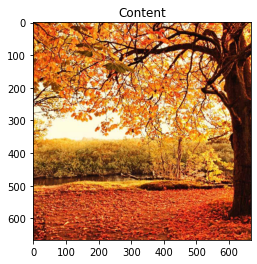

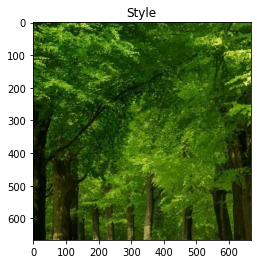

Execution time: 0.747422456741333 seconds
Loading content image...
Execution time: 0.7777767181396484 seconds
Loading style image...
Execution time: 0.8182857036590576 seconds
Start training...
Building the style transfer model..
Execution time: 0.020339488983154297 seconds
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


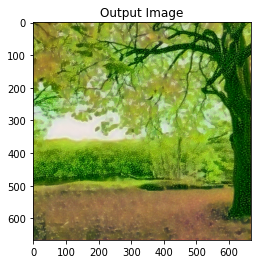

run [50]:
Style Loss : 239.406693 Content Loss: 44.102600
Execution time: 16.103291988372803 seconds



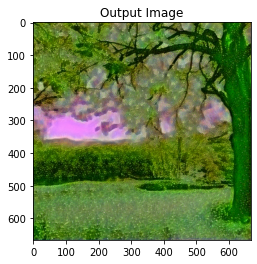

run [100]:
Style Loss : 119.943626 Content Loss: 44.698051
Execution time: 32.79747653007507 seconds



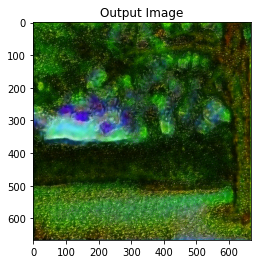

run [150]:
Style Loss : 252.668335 Content Loss: 56.977768
Execution time: 50.08342123031616 seconds



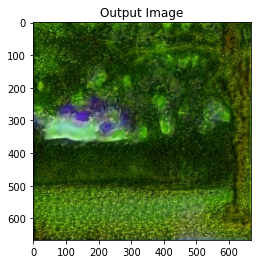

run [200]:
Style Loss : 13.264753 Content Loss: 45.092384
Execution time: 67.35366177558899 seconds



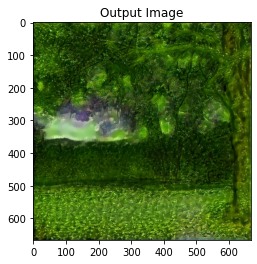

run [250]:
Style Loss : 4.115582 Content Loss: 34.269196
Execution time: 84.64141368865967 seconds



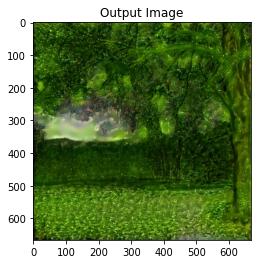

run [300]:
Style Loss : 2.400757 Content Loss: 28.961035
Execution time: 101.8883638381958 seconds



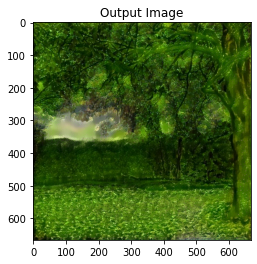

run [350]:
Style Loss : 1.642477 Content Loss: 25.935684
Execution time: 119.16551423072815 seconds



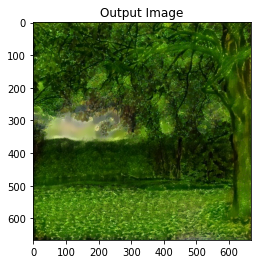

run [400]:
Style Loss : 1.521496 Content Loss: 24.320789
Execution time: 136.4618625640869 seconds



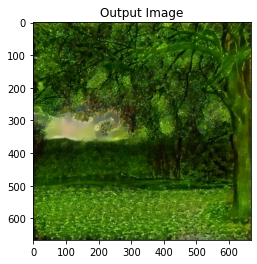

run [450]:
Style Loss : 1.351089 Content Loss: 23.768490
Execution time: 153.72224187850952 seconds



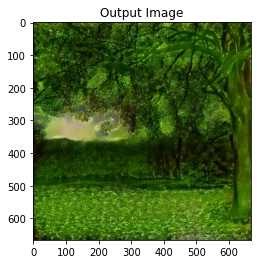

run [500]:
Style Loss : 1.765449 Content Loss: 22.464792
Execution time: 171.05868268013 seconds



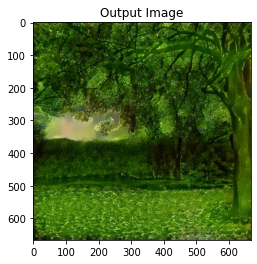

run [550]:
Style Loss : 0.881490 Content Loss: 21.839241
Execution time: 188.32376146316528 seconds

Saving the result...
Execution time: 192.5601499080658 seconds


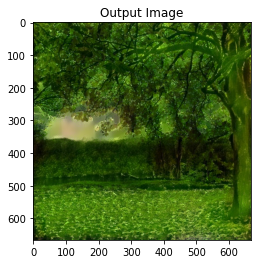

Execution time: 194.52073407173157 seconds


In [27]:
start_time = time.time()


nst_model = NST()
nst_model.run_NST(style_img_path, content_img_path)


print("Execution time: %s seconds" % (time.time() - start_time))

In [65]:
import gc
gc.collect()
torch.cuda.empty_cache()